Sr2RuO4 with Spin-Orbit Coupling
=================

We calculate the Green function of an effective impurity model for Sr2RuO4 with spin-orbit coupling.

In [4]:
# %load model.py
import sys, os
sys.path.append(os.getcwd() + '/../common')
from util import *

from triqs.gf import Gf, MeshImFreq, iOmega_n, inverse, MeshBrZone, MeshProduct
from triqs.lattice import BravaisLattice, BrillouinZone
from triqs.operators import c, c_dag, n
from triqs.operators.util import h_int_kanamori, U_matrix_kanamori
from itertools import product
from numpy import matrix, array, diag, pi
import numpy.linalg as linalg

from tight_binding_model import *

# ==== System Parameters ====
beta = 5.                       # Inverse temperature
mu = 0.                         # Chemical potential

U = 2.3                         # Density-density interaction
J = 0.4                         # Hunds coupling
SOC = 0.1                       # Spin-orbit coupling

n_iw = int(10 * beta)           # The number of positive Matsubara frequencies
n_k = 16                        # The number of k-points per dimension

spin_names = ['up', 'dn']       # The spins
orb_names = [0, 1, 2]           # The orbitals
idx_lst = list(range(len(spin_names) * len(orb_names)))
gf_struct = [('bl', idx_lst)]

TBL = tight_binding_model(lambda_soc=SOC)   # The Tight-Binding Lattice
TBL.bz = BrillouinZone(TBL.bl)
n_idx = len(idx_lst)


# ==== Local Hamiltonian ====
c_dag_vec = matrix([[c_dag('bl', idx) for idx in idx_lst]])
c_vec =     matrix([[c('bl', idx)] for idx in idx_lst])

h_0_mat = TBL._hop[(0,0,0)]
h_0 = (c_dag_vec * h_0_mat * c_vec)[0,0]

Umat, Upmat = U_matrix_kanamori(len(orb_names), U_int=U, J_hund=J)
op_map = { (s,o): ('bl',i) for i, (s,o) in enumerate(product(spin_names, orb_names)) }
h_int = h_int_kanamori(spin_names, len(orb_names), Umat, Upmat, J, off_diag=True, map_operator_structure=op_map)
h_loc = h_0 + h_int


# ==== Non-Interacting Impurity Green function  ====
iw_mesh = MeshImFreq(beta, 'Fermion', n_iw)
k_mesh = MeshBrZone(TBL.bz, n_k)
k_iw_mesh = MeshProduct(k_mesh, iw_mesh)

G0_k_iw = BlockGf(mesh=k_iw_mesh, gf_struct=gf_struct)
G0_iw = BlockGf(mesh=iw_mesh, gf_struct=gf_struct)

iw_vec = array([iw.value * np.eye(n_idx) for iw in iw_mesh])
k_vec = array([k.value for k in k_mesh])
e_k_vec = TBL.hopping(k_vec.T.copy() / 2. / pi).transpose(2, 0, 1)
mu_mat = mu * np.eye(n_idx)

G0_k_iw['bl'].data[:] = linalg.inv(iw_vec[None,...] + mu_mat[None,None,...] - e_k_vec[::,None,...])
G0_iw['bl'].data[:] = np.sum(G0_k_iw['bl'].data[:], axis=0) / len(k_mesh)


# ==== Hybridization Function ====
Delta = G0_iw.copy()
Delta['bl'] << iOmega_n + mu_mat - h_0_mat - inverse(G0_iw['bl'])


Greens Function G_bl with mesh Matsubara Freq Mesh of size 100, Domain: Matsubara domain with beta = 5, statistic = Fermion, positive_only : 0 and target_rank 2: 

Results
====

In [5]:
from triqs.plot.mpl_interface import oplot, plt
%matplotlib inline

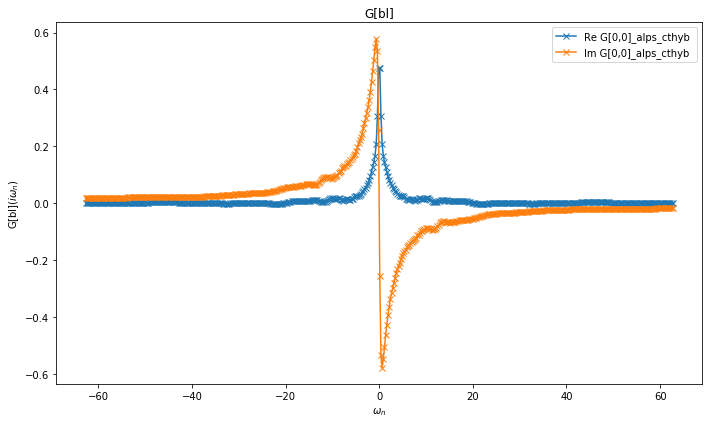

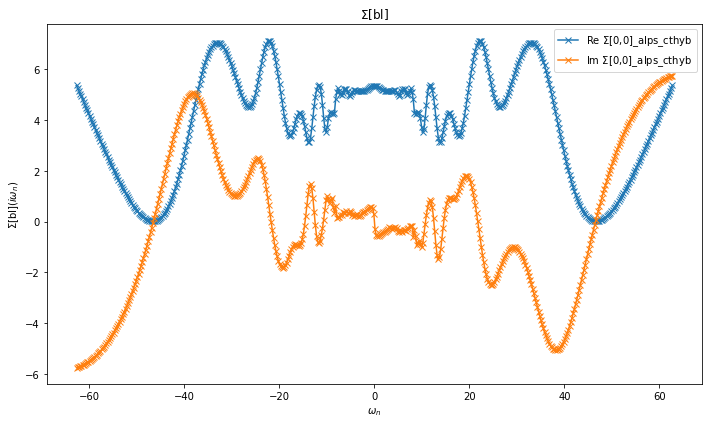

In [6]:
# %load ../common/plot.py
import sys, os
sys.path.append(os.getcwd() + "/..")
sys.path.append(os.getcwd() + "/../../common")
from model import *

from h5 import HDFArchive
from triqs.plot.mpl_interface import oplot, plt
from glob import glob
from os.path import basename

# === Load Green function for every solver and calculate self-energy

solver_lst = [ basename(f).strip('.h5') for f in glob('results/*.h5') ]
marker_lst = ['-x', '-+', '-^', '-v', '-<', '->', '-*', '-p']
G, Sigma = {}, {}

for solver in solver_lst:
    dat = HDFArchive('results/' + solver + '.h5','r')
    G[solver] = dat['G']
    Sigma[solver] = G0_iw.copy()
    Sigma[solver] << inverse(G0_iw) - inverse(G[solver])

# === For every block and solver, plot Green function and Self energy

block_lst = list(G[solver_lst[0]].indices)
n_blocks = len(block_lst)

for g, name in [[G, 'G'], [Sigma, '$\Sigma$']]:

    plt.subplots(n_blocks,1,figsize=(10,6*n_blocks))

    for i, block in enumerate(block_lst,1):
        fig = plt.subplot(n_blocks,1,i)
        fig.set_title(name + "[" + block + "]")
        for solver in solver_lst:
            marker = marker_lst[solver_lst.index(solver)]
            oplot(g[solver][block][0,0], marker, name = name + "[0,0]_%s" % solver)
        plt.xlabel("$\omega_n$")
        plt.ylabel(name + "[" + block + "]$(i\omega_n)$")

    plt.tight_layout()
    plt.show()


Deviations
======

We present a table containing deviations between the different solvers measured via

$$||G_{\rm Solver_1} - G_{\rm Solver_2}||_\infty$$

In [7]:
import numpy as np

for block in block_lst:
    deviations = [[ np.amax(np.abs(G[s1][block].data - G[s2][block].data)) for s1 in solver_lst ] \
                    for s2 in solver_lst ]
    
    print("\t\t    Deviations for Block " + block)
    print("\t\t -----------------------------------")

    row_format ="{:>15}" * (len(solver_lst) + 1)
    print(row_format.format("", *solver_lst))
    row_format ="{:>15}" + "{:>15.2E}" * len(solver_lst)
    for solver, row in zip(solver_lst, deviations):
        print(row_format.format(solver, *row))
        
    print("\n\n")

		    Deviations for Block bl
		 -----------------------------------
                    alps_cthyb
     alps_cthyb       0.00E+00



